# Pool-based Multilabel Active Learning - Getting Started

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](<colab_link>)

**Notebook Dependencies**

Uncomment the following cell to install all dependencies for this tutorial.

In [1]:
# !pip install scikit-activeml
# !pip install tqdm

The main purpose of this tutorial is to ease the implementation of our library `scikit-activeml` to new users. `scikit-activeml` is a library that executes the most important query strategies. It is built upon the well-known machine learning frame-work `scikit-learn`, which makes it user-friendly. For better understanding, we show an exemplary multilabel active learning cycle here. Let's start by importing the relevant packages from both `scikit-learn` and `scikit-activeml`.

In [2]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import f1_score

from skactiveml.classifier import SklearnMultilabelClassifier, SklearnClassifier
from skactiveml.pool import RandomSampling, UncertaintySampling, DropQuery, Badge, TypiClust, MMC, LabelCardinalityInconsistency
from skactiveml.utils import MISSING_LABEL, call_func

import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

## Data Set Generation
We generate a data set of `n_samples=100` data points with `num_classes=5` classes where the average label density is `n_labels=3` from the `make_multilabel_classification` method of `scikit-learn`. This method also returns the true labels of each data point. In practice, however, we do not know these labels unless we ask an oracle. The labels are stored in `Y_true`, which acts as an oracle.

Multilabel compare to multiclass classification has a one-hot-encoded vector as its target `Y`, because classes can co-exist, such that one sample can be identified by more then one class.

In [3]:
X, Y_true = make_multilabel_classification(n_samples=1000,
                                           n_features=10,
                                           n_classes=5,
                                           n_labels=3,
                                           random_state=1)

## Classification

In [4]:
def topk_accuracy(preds, targets, topk=1):
    """
    Compute the Top-K Accuracy for multi-class or multi-label predictions using NumPy.

    Args:
        preds (np.ndarray): Prediction probabilities of shape (N, C).
        targets (np.ndarray): One-hot encoded ground truth labels of shape (N, C).
        topk (int): Number of top predictions to consider.

    Returns:
        float: Top-K accuracy.
    """
    # Get the indices of the top-k predictions
    topk_pred_indices = np.argsort(-preds, axis=1)[:, :topk]

    # Convert one-hot encoded targets to indices for positive cases
    correct_positive = np.any(targets[np.arange(targets.shape[0])[:, None], topk_pred_indices], axis=1)

    # Combine correct predictions
    correct = correct_positive.sum()

    # Determine total number of samples to consider
    total = len(targets)

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0.0

    return accuracy

In [5]:
# parameter setup
seed: int = 42
n_cycles: int = 30
batch_size: int = 10

In [6]:
strategies = {
    "Random": RandomSampling(random_state=seed),
    "Entropy_sum": UncertaintySampling(random_state=seed, ml_agg=np.nansum),
    "Entropy_max": UncertaintySampling(random_state=seed, ml_agg=np.max),
    "DropQuery_sum": DropQuery(random_state=seed, n_dropout_samples=20, multilabel_aggregation_fn=np.sum),
    "DropQuery_max": DropQuery(random_state=seed, n_dropout_samples=20, multilabel_aggregation_fn=np.max),
    "Badge": Badge(random_state=seed),
    "Typiclust": TypiClust(random_state=seed),
    "MMC": MMC(random_state=seed),
    "LCI": LabelCardinalityInconsistency(random_state=seed),
}

### Evaluate Sampling Strategies

In [7]:
history_t1 = {name: [] for name in strategies.keys()}
history_f1 = {name: [] for name in strategies.keys()}

for name, qs in strategies.items():
    clf = SklearnMultilabelClassifier(MultiOutputClassifier(LogisticRegression(random_state=seed)), classes=np.arange(Y_true.shape[-1]), random_state=seed)
    discriminator = SklearnClassifier(LogisticRegression(random_state=seed), random_state=seed)

    Y = np.full(shape=Y_true.shape, fill_value=MISSING_LABEL)
    clf.fit(X, Y)
    history_t1[name].append(topk_accuracy(clf.predict(X), Y_true))
    history_f1[name].append(f1_score(clf.predict(X), Y_true, average="macro"))
    for c in tqdm(range(n_cycles), desc=name):
        query_idx = call_func(qs.query, X=X, y=Y, batch_size=batch_size, clf=clf, discriminator=discriminator)

        Y[query_idx] = Y_true[query_idx]
        clf.fit(X, Y)
        pred = clf.predict_proba(X)
        history_t1[name].append(topk_accuracy(clf.predict(X), Y_true))
        history_f1[name].append(f1_score(clf.predict(X), Y_true, average="macro"))


Random:   0%|          | 0/30 [00:00<?, ?it/s]

Entropy_sum:   0%|          | 0/30 [00:00<?, ?it/s]

Entropy_max:   0%|          | 0/30 [00:00<?, ?it/s]

DropQuery_sum:   0%|          | 0/30 [00:00<?, ?it/s]

DropQuery_max:   0%|          | 0/30 [00:00<?, ?it/s]

Badge:   0%|          | 0/30 [00:00<?, ?it/s]

Typiclust:   0%|          | 0/30 [00:00<?, ?it/s]

MMC:   0%|          | 0/30 [00:00<?, ?it/s]

LCI:   0%|          | 0/30 [00:00<?, ?it/s]

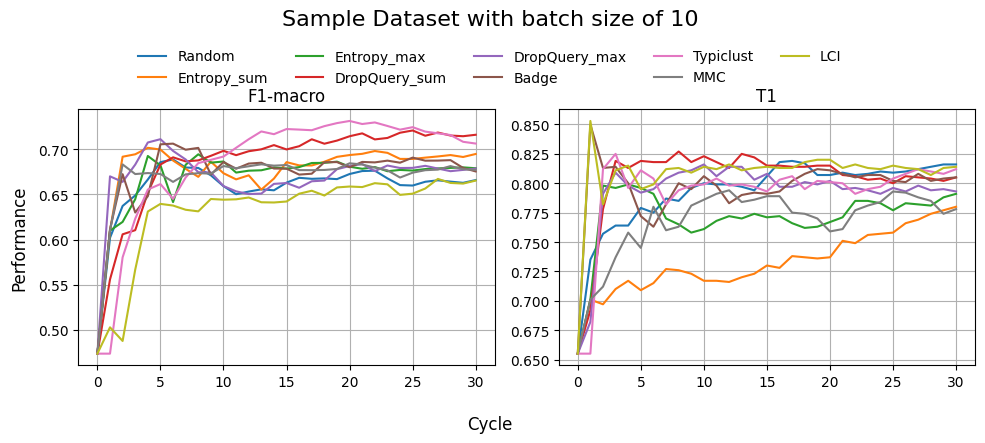

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, tight_layout=True)
histories = {"F1-macro": history_f1, "T1": history_t1}
for ax, (metric, history) in zip(axes, histories.items()):
    for name, hist in history.items():
        ax.plot(range(0, n_cycles+1), hist, label=name)
    ax.set_title(metric)
    ax.grid(True)
fig.legend(*axes[0].get_legend_handles_labels(), loc="upper center", bbox_to_anchor=(0.5, 1), ncol=5, frameon=False)
fig.suptitle(f"Sample Dataset with batch size of {batch_size}", fontsize=16, y=1.07)
fig.supxlabel("Cycle")
fig.supylabel("Performance")
plt.show()